<a href="https://colab.research.google.com/github/jfink09/optical-funduscopic-convolutional-neural-network/blob/main/FundusNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libraries
import torch
from torch import nn

In [3]:
# Set up device for device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1.0. Get the data

In [1]:
# Import libraries
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "fundusapp"

# Download it and prepare image folder if it does not already exist
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download.")
else:
  print(f"{image_path} does not exist...creating one")
  image_path.mkdir(parents=True,exist_ok=True)

# Download normal and cataracts data
with open(data_path / "fundusapp.zip", "wb") as f:
  #request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/data/normal_cataracts.zip")
  request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/data/fundusapp.zip")
  print("Downloading normal and cataracts data...")
  f.write(request.content)

# Unzip normal and cataracts data
with zipfile.ZipFile(data_path / "fundusapp.zip", "r") as zip_ref:
  print("Unzipping normal and cataracts data...")
  zip_ref.extractall(image_path)

data/fundusapp does not exist...creating one
Unzipping normal and cataracts data...


### 2.0. Data preparation and exploration

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/fundusapp'.
There are 2 directories and 1 images in 'data/fundusapp/test'.
There are 0 directories and 18 images in 'data/fundusapp/test/disease'.
There are 0 directories and 12 images in 'data/fundusapp/test/normal'.
There are 2 directories and 1 images in 'data/fundusapp/train'.
There are 0 directories and 72 images in 'data/fundusapp/train/disease'.
There are 0 directories and 48 images in 'data/fundusapp/train/normal'.


In [5]:
# Set up train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/fundusapp/train'), PosixPath('data/fundusapp/test'))

### 3.0. Visualize an image

Write code to:

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata

data/fundusapp/train/disease/disease35.jpg
disease
Random image path: data/fundusapp/train/disease/disease35.jpg
Image class: disease
Image height: 1880
Image width: 2816


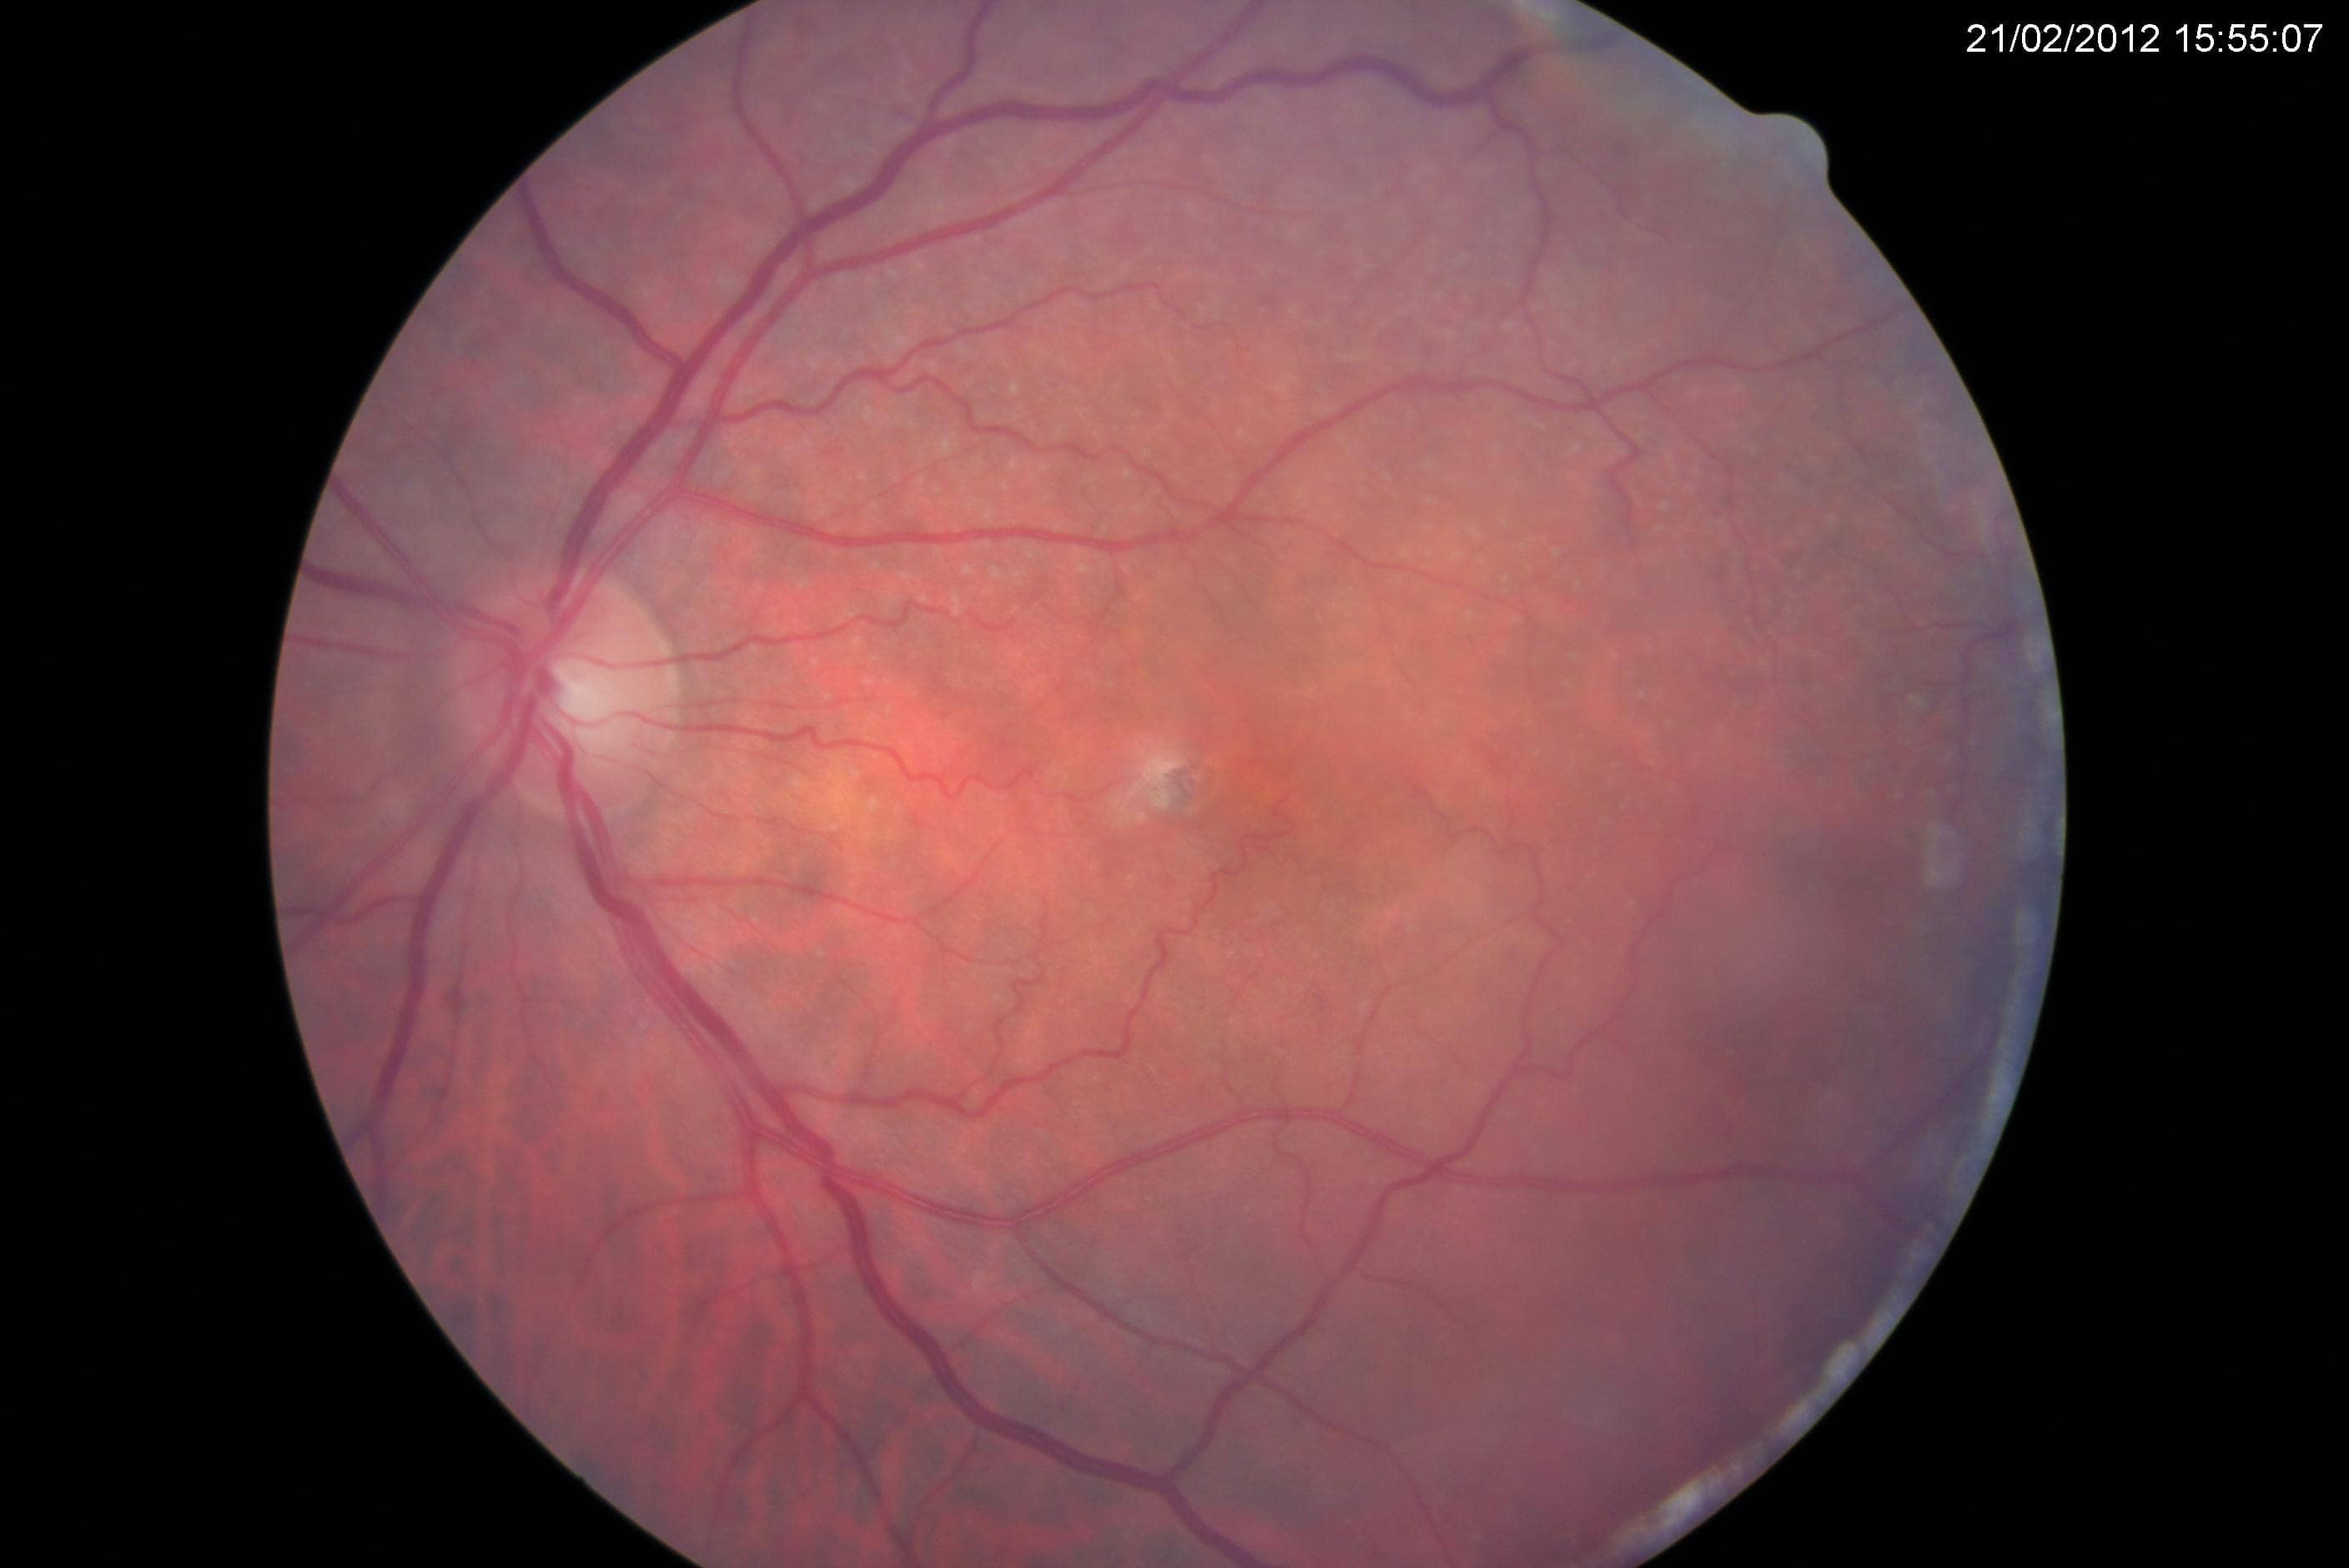

In [6]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

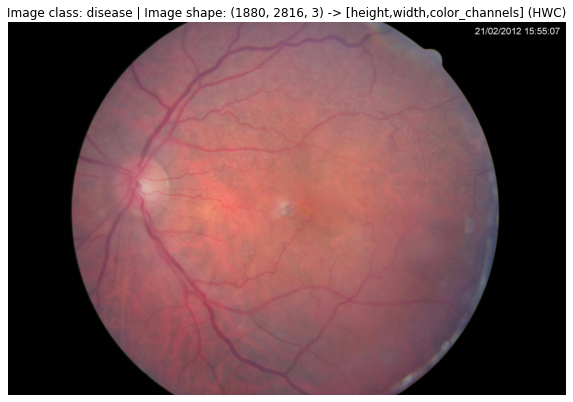

In [7]:
# Visualize with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channels] (HWC)")
plt.axis(False);

In [8]:
# Show the image in numerical format
img_as_array

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

### 3.0. Transforming data

Before we can use our image data with PyTorch:

1. Turn the target data into tensors (numerical representation of the images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` and we will call them `Dataset` and `DataLoader`

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1. Transforming data with `torchvision.transforms`

Transforms help get images ready to be used with model/perform data augmentation.

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize image to 64x64 since we used tiny VGG architecture
    transforms.Resize(size=(512,512)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.0000, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

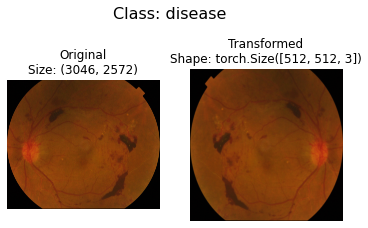

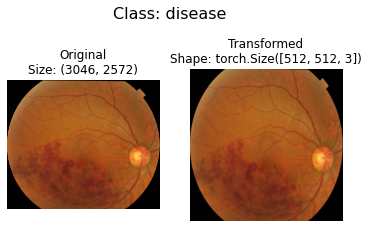

In [12]:
def plot_transformed_images(image_paths,transform,n=2,seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs. the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot the target image
      transformed_image = transform(f).permute(1,2,0) # Will need to change the shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=2,
                        seed=42)

### 4.0. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 120
     Root location: data/fundusapp/train
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 30
     Root location: data/fundusapp/test
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
train_dir, test_dir

(PosixPath('data/fundusapp/train'), PosixPath('data/fundusapp/test'))

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['disease', 'normal']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'disease': 0, 'normal': 1}

In [17]:
# Class the lengths of our dataset
len(train_data), len(test_data)

(120, 30)

In [18]:
train_data.samples[0]

('data/fundusapp/train/disease/disease1.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n {img}")
print(f"Image Shape:\n {img.shape}")
print(f"Image Datatype:\n {img.dtype}")
print(f"Image Label:\n {label}")
print(f"Label Datatype:\n {type(label)}")

Image Tensor:
 tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0

In [20]:
class_names[label]

'disease'

Original Shape: torch.Size([3, 512, 512]) -> [color_channels, height, width]
Image Permute: torch.Size([512, 512, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'disease')

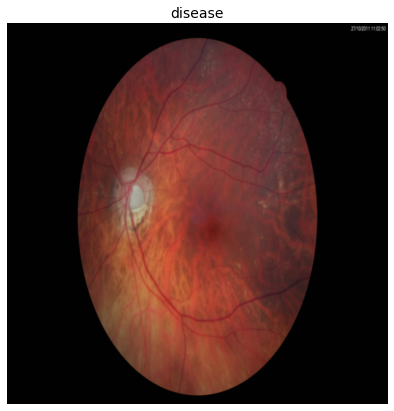

In [21]:
# Rearrange the other dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original Shape: {img.shape} -> [color_channels, height, width]")
print(f"Image Permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

### 4.1. Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [22]:
import os
os.cpu_count()

2

In [23]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f5504e8c990>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5504e8c950>)

In [24]:
len(train_dataloader), len(test_dataloader)

(120, 30)

In [25]:
len(train_data), len(test_data)

(120, 30)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if wanted
print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 512, 512]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([1])


### 5.0. Option 2: Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get class names as dictionary from Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it does not mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['disease', 'normal'], {'disease': 0, 'normal': 1})

### 5.1. Creating a helper function to get class names

Make a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class names are not found (may be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them

In [29]:
import glob, os

for root, dirs, files in os.walk('/'):
    i = 0
    for file in files:
        if file.endswith('.DS_Store'):
            path_ds = os.path.join(root, file)
            print(f"Deleting: %s {path_ds}")
            if os.remove(path_ds):
                print("Unable to delete!")
            else:
                print("Deleted...")
                i += 1
print(f"Files Deleted: %d {i}")

Deleting: %s /content/data/fundusapp/test/.DS_Store
Deleted...
Deleting: %s /content/data/fundusapp/train/.DS_Store
Deleted...
Deleting: %s /datalab/web/node_modules/engine.io/node_modules/ws/lib/.DS_Store
Deleted...
Deleting: %s /datalab/web/node_modules/engine.io-client/node_modules/ws/lib/.DS_Store
Deleted...
Files Deleted: %d 0


In [30]:
# Set up path for target directory
target_directory = train_dir
print(f"Target Directory: {target_directory}")

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: data/fundusapp/train


['disease', 'normal']

In [31]:
list(os.scandir(target_directory))

[<DirEntry 'disease'>, <DirEntry 'normal'>]

In [32]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}... please check file structure.")
  
  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [33]:
find_classes(target_directory)

(['disease', 'normal'], {'disease': 0, 'normal': 1})

### 5.2. Create a custom `Dataset` to replicate `ImageFolder`

To create a custom dataset:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we want to get data from) as well as a transform if we want to transform the data
3. Create several attributes:
  * Paths - paths of the images
  * Transform - the transform we want to use
  * Classes - a list of our target classes
  * Class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()` to open images
5. Overwrite the `__len()__` method to return the length of the dataset
6. Overwrite the `__getitem()` method to return a given sample when passed an index

In [34]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize the custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Set up transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
    
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]
    
    # Transform inf necessary
    if self.transform:
      return self.transform(img), class_idx # Return data, label (X, y)
    else:
      return img, class_idx # Return untransformed image and label

In [35]:
# Create a transform
from torchvision.transforms import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.ToTensor()
])

In [36]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [37]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f5504e8c490>,
 <__main__.ImageFolderCustom at 0x7f5504e8cd50>)

In [38]:
len(train_data), len(train_data_custom)

(120, 72)

In [39]:
len(test_data), len(test_data_custom)

(30, 18)

In [40]:
train_data_custom.classes

['disease', 'normal']

In [41]:
train_data_custom.class_to_idx

{'disease': 0, 'normal': 1}

In [42]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3. Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Set up a Matplotlib plot
6. Loop through the random sample images and plot them with Matplotlib
7. Make sure the dimensions of the images line up with Matplotlib (HWC)

In [43]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, n should not be larger than 10, setting to 10 and removing shape display.")
  
  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Set up plot

  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with Matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [C,H,W] -> [H,W,C]

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape {targ_image_adjust.shape}"
    plt.title(title)

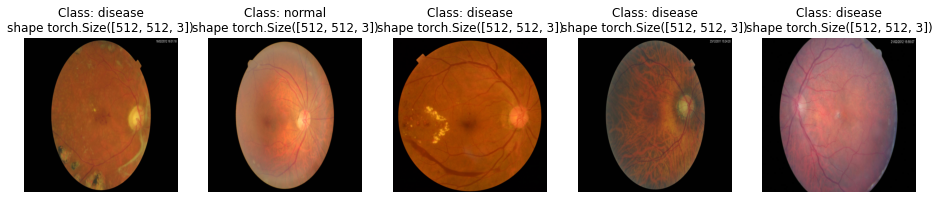

In [44]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display, n should not be larger than 10, setting to 10 and removing shape display.


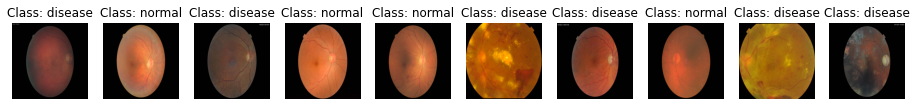

In [45]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4. Turn custom loaded images into `DataDoader`s

In [46]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f5503e2bdd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5503e2be10>)

In [47]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

### 6.0. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

One type of data augmentation to train PyTorch vision models to state of the art levels - trivialaugment

In [48]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/fundusapp/test/disease/disease84.jpg'),
 PosixPath('data/fundusapp/test/disease/disease88.jpg'),
 PosixPath('data/fundusapp/test/disease/disease89.jpg'),
 PosixPath('data/fundusapp/test/disease/disease75.jpg'),
 PosixPath('data/fundusapp/test/disease/disease76.jpg'),
 PosixPath('data/fundusapp/test/disease/disease73.jpg'),
 PosixPath('data/fundusapp/test/disease/disease82.jpg'),
 PosixPath('data/fundusapp/test/disease/disease81.jpg'),
 PosixPath('data/fundusapp/test/disease/disease86.jpg'),
 PosixPath('data/fundusapp/test/disease/disease79.jpg')]

In [49]:
# Trivalaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.ToTensor()
])

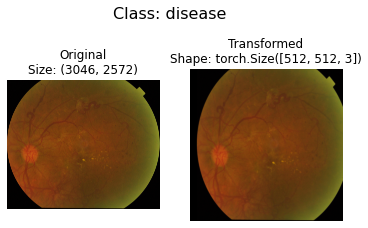

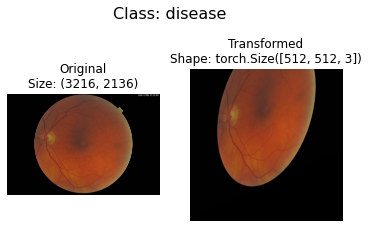

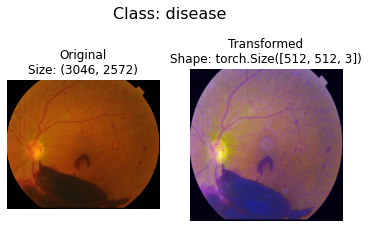

In [52]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

### 7.0. Model 0: TinyVGG without data augmentation

Replicate the TinyVGG arcitecture from the CNN explainer website - https://poloclub.github.io/cnn-explainer/

### 7.1. Creating transforms and loading data for model 0

In [53]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.ToTensor()
])

In [54]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Set up batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 7.2. Create TinyVGG model class

In [55]:
class TinyVGG(nn.Module):
  """
  Model arcitecture copying TinyVGG from CNN Explainer - https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2) # Default stride value is the same as the kernel size for MaxPool2d
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2) # Default stride value is the same as the kernel size for MaxPool2d
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*125*125,
                  out_features=output_shape)
    )
  
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x
    # return self.classifer(self.conv_block_2(self.conv_block_1(x))) # Benefits from operator fusion

In [56]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # Number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=156250, out_features=2, bias=True)
  )
)

### 7.3. Try a forward pass on a single image (to test the model)

In [57]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

In [58]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[0.0080, 0.0084],
        [0.0100, 0.0098],
        [0.0086, 0.0104],
        [0.0114, 0.0108],
        [0.0113, 0.0089],
        [0.0106, 0.0109],
        [0.0106, 0.0085],
        [0.0103, 0.0103],
        [0.0106, 0.0121],
        [0.0101, 0.0098],
        [0.0110, 0.0090],
        [0.0101, 0.0113],
        [0.0103, 0.0091],
        [0.0113, 0.0092],
        [0.0088, 0.0092],
        [0.0101, 0.0098],
        [0.0097, 0.0090],
        [0.0091, 0.0085],
        [0.0104, 0.0114],
        [0.0105, 0.0108],
        [0.0099, 0.0106],
        [0.0111, 0.0119],
        [0.0108, 0.0112],
        [0.0108, 0.0116],
        [0.0107, 0.0107],
        [0.0114, 0.0101],
        [0.0085, 0.0077],
        [0.0105, 0.0083],
        [0.0117, 0.0111],
        [0.0111, 0.0080],
        [0.0109, 0.0108],
        [0.0098, 0.0093]], grad_fn=<AddmmBackward0>)

### 7.4. Use `torchinfo` to get an idea of the shapes going through our model (so we do not have to print out shapes)

In [59]:
# Install torchinfo, import if it is available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,512,512])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 254, 254]         --
│    └─Conv2d: 2-1                       [1, 10, 510, 510]         280
│    └─ReLU: 2-2                         [1, 10, 510, 510]         --
│    └─Conv2d: 2-3                       [1, 10, 508, 508]         910
│    └─ReLU: 2-4                         [1, 10, 508, 508]         --
│    └─MaxPool2d: 2-5                    [1, 10, 254, 254]         --
├─Sequential: 1-2                        [1, 10, 125, 125]         --
│    └─Conv2d: 2-6                       [1, 10, 252, 252]         910
│    └─ReLU: 2-7                         [1, 10, 252, 252]         --
│    └─Conv2d: 2-8                       [1, 10, 250, 250]         910
│    └─ReLU: 2-9                         [1, 10, 250, 250]         --
│    └─MaxPool2d: 2-10                   [1, 10, 125, 125]         --
├─Sequentia

### 7.5. Create train and test loops functions 

*   `train_step()` - takes in a model and dataloader and trains the model on the dataloader
*   `test_step()` - takes in a model and dataloader and tests the model on the dataloader

In [60]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  
  # Put the model in train mode
  model.train()

  # Set up train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # Output model logits (raw output of the model is logits)

    # 2. Calculate the loss
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per epoch per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [61]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6. Creating a `train()` function to combine `train_step()` and `test_step()`

In [62]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [63]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9536 | train_acc: 0.4427 | test_loss: 2.6801 | test_acc: 0.4000
Epoch: 2 | train_loss: 2.0661 | train_acc: 0.3750 | test_loss: 1.6896 | test_acc: 0.6000
Epoch: 3 | train_loss: 1.2338 | train_acc: 0.4661 | test_loss: 0.9135 | test_acc: 0.4000
Epoch: 4 | train_loss: 0.8785 | train_acc: 0.3984 | test_loss: 0.6588 | test_acc: 0.6000
Epoch: 5 | train_loss: 0.6908 | train_acc: 0.6120 | test_loss: 0.7559 | test_acc: 0.6000
Total training time: 255.168 seconds


In [64]:
model_0_results

{'train_loss': [2.953630343079567,
  2.0661131143569946,
  1.2337991446256638,
  0.8785051107406616,
  0.6907607018947601],
 'train_acc': [0.4427083333333333,
  0.375,
  0.4661458333333333,
  0.3984375,
  0.6119791666666666],
 'test_loss': [2.680133581161499,
  1.6895626783370972,
  0.9135482907295227,
  0.6588054299354553,
  0.7559012770652771],
 'test_acc': [0.4, 0.6, 0.4, 0.6, 0.6]}

### 7.8. Plot the loss curves of model_0

A **loss curve** is a way of tracking a model's progress over time

In [65]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [66]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

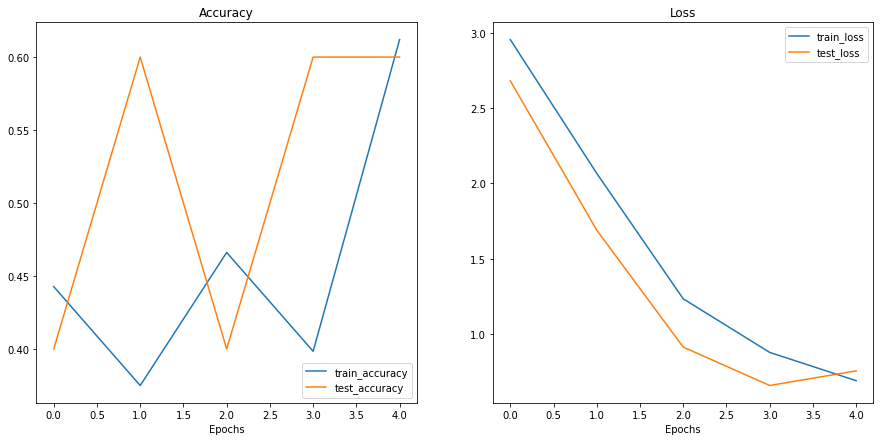

In [67]:
plot_loss_curves(model_0_results)

### 8.0. What should an ideal loss curve look like?

Loss curves are used to troubleshoot a model. Want the loss curve to go down and the accuracy curve to go up over time.

### 9.0. Model 1: Tiny VGG with data augmentation

Try another modeling experiment using the same model as before, but with some data augmentation

### 9.1. Create transform with data augmentation

In [68]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() # To make the images in tensor format for the model
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(512,512)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `DataLoader`s with data augmentation

In [69]:
# Turn the image folders into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [70]:
# Turn the datasets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple ,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)

### 9.3. Construct and train model 1

Using the same model architecture, but augmenting the training data to see if accuracy improves.

In [71]:
# Create model_1 and send to target device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=156250, out_features=2, bias=True)
  )
)

# Create a loss function and an optimizer and call the train function to train and evaluate the model (we now have a model and dataloaders)

In [72]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Set up loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Star tthe timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS) # Can add device=device if using a GPU

# End timer and print how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3202 | train_acc: 0.5000 | test_loss: 2.6028 | test_acc: 0.4000
Epoch: 2 | train_loss: 1.4351 | train_acc: 0.5677 | test_loss: 1.6937 | test_acc: 0.6000
Epoch: 3 | train_loss: 1.1211 | train_acc: 0.5964 | test_loss: 1.0195 | test_acc: 0.4000
Epoch: 4 | train_loss: 1.0332 | train_acc: 0.4036 | test_loss: 0.6799 | test_acc: 0.6000
Epoch: 5 | train_loss: 0.8496 | train_acc: 0.6042 | test_loss: 0.8007 | test_acc: 0.6000
Total training time for model_1: 243.789 seconds


# Data augmentation helps with overfitting, and our model_0 loss curve decreased overtime, so since the model was not overfitting, data augmentation in model_1 made the accuracy worse.

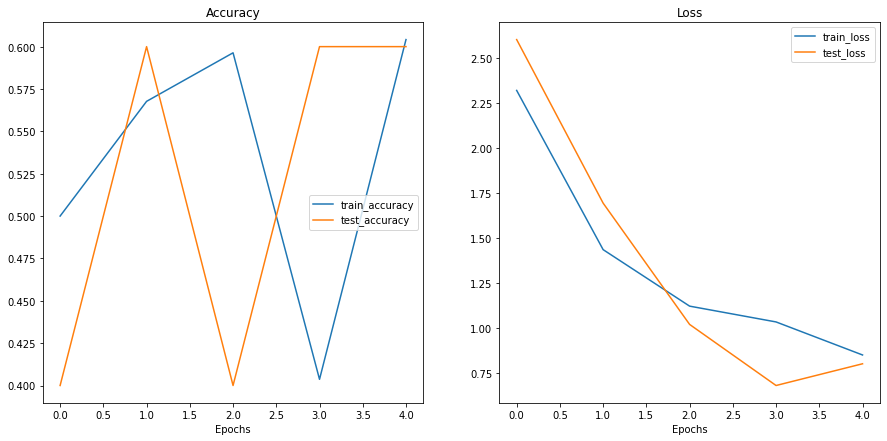

In [73]:
plot_loss_curves(model_1_results)

### 10.0. Comparing model results

After evaluating the modeling experiments on their own, compare them with each other

To do this:
1. Hard coding (what we are doing)
2. PyTorch and Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights and biases - https://wandb.ai/site
4. MLFlow - https://mlflow.org/

In [74]:
import pandas as pd
model_0_df = pd. DataFrame(model_0_results)
model_1_df = pd. DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,2.953630,0.442708,2.680134,0.4
1,2.066113,0.375000,1.689563,0.6
2,1.233799,0.466146,0.913548,0.4
3,0.878505,0.398438,0.658805,0.6
4,0.690761,0.611979,0.755901,0.6


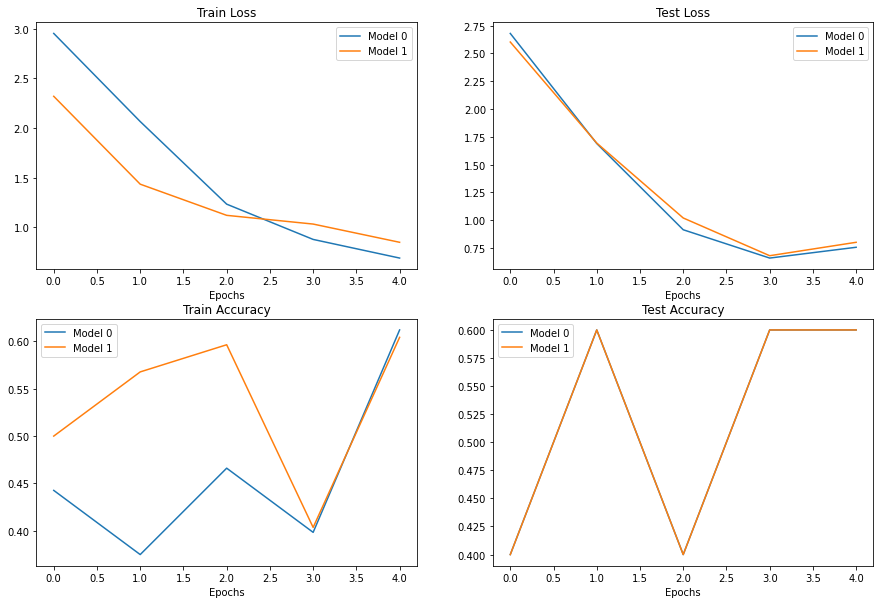

In [75]:
# Set up a plot
plt.figure(figsize=(15,10))

# Get the number of epochs
epochs = range(len(model_0_df))

# Plot the train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot the test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot the train accuracy
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot the test accuracy
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

### 11.0. Making a prediction on a custom image

Now that the model is trained on custom data, we can make a prediction on a sample/image that is not in either the training or testing dataset.

In [76]:
# Download a custom image
import requests

# Set up a custom image path
custom_image_path = data_path / "normal61.jpg"

# Download the image if it does not already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need the raw file link
    request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/images/normal61.jpg")
    #request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/images/cataract_103.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"Custom image path already exists...skipping download")

### 11.1. Loading in a custom image with PyTorch

Make sure the custom image is in the same format, the data was trained on.

* In tensor form with datatype `torch.float32`
* Of shape 64x64x3
* On the right device

Read an image into PyTorch using - https://pytorch.org/vision/main/generated/torchvision.io.read_image.html

In [77]:
custom_image_path

PosixPath('data/normal61.jpg')

In [78]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

print(f"Custom Image Tensor:\n {custom_image_uint8}")
print(f"Custom Image Shape:\n {custom_image_uint8.shape}")
print(f"Custom Image Datatype:\n {custom_image_uint8.dtype}")

Custom Image Tensor:
 tensor([[[1, 1, 1,  ..., 2, 2, 2],
         [1, 1, 1,  ..., 2, 2, 2],
         [1, 1, 1,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)
Custom Image Shape:
 torch.Size([3, 240, 240])
Custom Image Datatype:
 torch.uint8


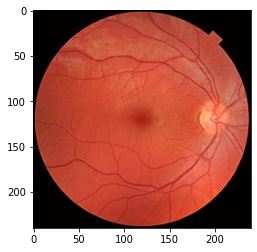

In [79]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2. Make a prediction on a custom image with a trained PyTorch model

In [80]:
# Load in the custom image and convert it to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.

In [81]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(512,512))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original Shape: {custom_image.shape}")
print(f"Transformed Image Shape: {custom_image_transformed.shape}")

Original Shape: torch.Size([3, 240, 240])
Transformed Image Shape: torch.Size([3, 512, 512])


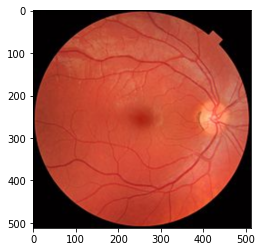

In [82]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [83]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [84]:
# With an added batch size by unsqeeze(0)
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.7599, -0.7510]])

Note: To make a prediction on a custom image, it needs to be formated the same way the other images were trained on:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (`torch.float32`)
* Make sure the image was the same shape as the data the model was trained on (3,64,64) with batch size...(1,3,64,64)
* Make sure the image was on the same device as the model

In [85]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.8192, 0.1808]])

In [86]:
# Convert the prediction probabilities to prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([0])

In [87]:
class_names[custom_image_pred_label]

'disease'

### 11.3. Putting custom image prediction together: building a function

Ideal outcome is a function where we pass an image path to and have the model predict on that image and plot the image and prediction

In [88]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the prediction"""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
      # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
      target_image = target_image.unsqueeze(0)

      # Make a prediction on the image with an extra dimension
      target_image_pred = model(target_image.to(device)) # Make sure the target image is on the target device
    
    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the predicion and prediction probability
    plt.imshow(target_image.squeeze().permute(1,2,0)) # Remove batch dimension and rearrange shape to be HWC
    if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

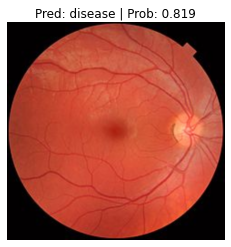

In [89]:
# Pred on the custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)